# 1.  U-Net trained on the MoNuSeg data set
This notebook is for training a model on the data from the MonSeg challenge. The goal is to train a model that will be used to find cell instances in the data from the SweBCH91RT study.

In [1]:
import random
import json
from itertools import cycle
import os

import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from PIL import Image
from PIL import Image, ImageDraw
from skimage.draw import polygon
from skimage.io import imread, imshow
from skimage.transform import resize
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from keras.utils import Sequence
from keras.utils.np_utils import to_categorical   
from keras.models import Model, load_model
from keras.layers import Input, multiply
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras

import wandb
from wandb.keras import WandbCallback

from weighted_loss_unet import make_weighted_loss_unet, my_loss

from augmented_sequence import AugmentedSequence
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
BATCH_SIZE = 5

## Data augmentation

In [2]:
seq = iaa.Sequential([
    iaa.CropToFixedSize(width=round(IMG_WIDTH*1.5), height=round(IMG_HEIGHT*1.5)),
    iaa.flip.Flipud(p=0.25),
    iaa.flip.Fliplr(p=0.25),
    iaa.Affine(rotate=(0,360),
               scale={"x":(0.9, 1.1), "y":(0.9, 1.1)},
               shear=(-8, 8)),
    iaa.CropToFixedSize(width=IMG_WIDTH, height=IMG_HEIGHT, position="center"),
    #iaa.Sometimes(0.1, iaa.SigmoidContrast(gain=(1, 2), cutoff=(0.4, 0.6))),
    #iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0.0, 3.0)))
    #iaa.Sometimes(0.2, iaa.EdgeDetect((0,0.5)))
])

val_sequential = iaa.Sequential([
    iaa.CropToFixedSize(width=IMG_WIDTH, height=IMG_HEIGHT, position="center"),
])

from dataset import Monuseg, Bns
train1, test= Bns().make_split()
train1, val1= train1.make_split()

train2, test= Monuseg().make_split()
train2, val2= train2.make_split()


train_seq = AugmentedSequence([train1, train2], BATCH_SIZE, seq, IMG_WIDTH, IMG_HEIGHT)
val_seq = AugmentedSequence([val1, val2], BATCH_SIZE, val_sequential, IMG_WIDTH, IMG_HEIGHT)


## Sanity check

(5, 256, 256, 3) (5, 256, 256, 2) (5, 256, 256, 2)
uint8 float32 float32


<Figure size 720x720 with 0 Axes>

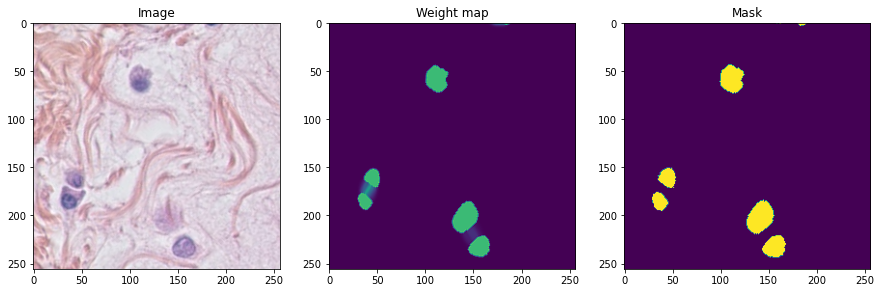

<Figure size 720x720 with 0 Axes>

In [3]:
(img_b, wmap_b), mask_b = train_seq[1]
print(img_b.shape, wmap_b.shape, mask_b.shape)
print(img_b.dtype, wmap_b.dtype, mask_b.dtype)
img = img_b[0]
wmap = wmap_b[0,...,1]
mask = mask_b[0,...,1]
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.imshow(img)
plt.title("Image")
plt.subplot(132)
plt.imshow(wmap)
plt.title("Weight map")
plt.subplot(133)
plt.imshow(mask)
plt.title("Mask")
plt.figure(figsize=(10,10))

## Train U-Net
The U-Net, along with the weight map loss function, was implemented by [jaidevd](https://jaidevd.github.io/posts/weighted-loss-functions-for-instance-segmentation/).

In [4]:
def iou(y_true, y_pred):
    y_true = y_true[0]
    intersection = K.sum(K.abs(y_true[...,1] * y_pred[...,1]), axis=-1)
    union = K.sum(K.abs(y_true[...,1]) + K.abs(y_pred[...,1]), axis=-1)
    jac = (intersection) / (union)
    return (1-jac)

In [ ]:
#tf.compat.v1.disable_eager_execution()
name = 'unet_model'
model_dir = './models/unet'
os.makedirs(model_dir, exist_ok=True)
import os
if f"{name}.h5" in os.listdir(model_dir):
    print("Loading existing model...", end='')
    model = keras.models.load_model(f'{model_dir}/{name}.h5',
                        custom_objects={'my_loss' : my_loss, 'iou': iou})
    print("Done!")
else:
    wandb.init(project="swebcg91rt-net")
    model = make_weighted_loss_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), 2, is_training = True)
    model.compile(optimizer='adam', loss=my_loss, metrics=[iou])
    model.fit(train_seq, validation_data=val_seq, epochs=300, callbacks=[WandbCallback()]) 
    
    # Save model to wandb
    model.save(os.path.join(wandb.run.dir, "model.h5"))
    model.save(f'{model_dir}/{name}.h5')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/300
29/29 [==============================] - 6s 198ms/step - loss: 0.4211 - iou: nan - val_loss: 0.4116 - val_iou: 0.5626
Epoch 2/300
29/29 [==============================] - 6s 211ms/step - loss: 0.2812 - iou: nan - val_loss: 0.2944 - val_iou: 0.6551
Epoch 3/300
29/29 [==============================] - 7s 225ms/step - loss: 0.2465 - iou: nan - val_loss: 0.2778 - val_iou: 0.7107
Epoch 4/300
29/29 [==============================] - 6s 201ms/step - loss: 0.2667 - iou: nan - val_loss: 0.2737 - val_iou: 0.7035
Epoch 5/300
29/29 [==============================] - ETA: 0s - loss: 0.2233 - iou: nan

# Post-processing
We use some of the techniques found in the [NucleAIzer Paper](https://www.sciencedirect.com/science/article/pii/S2405471220301174).
1. Descide on optimal threshold.
2. Remove small holes.
3. Remove small objects.

In [ ]:
# Our inference model won't take a weight map as an input.
model_inference = make_weighted_loss_unet((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), 2, False)
model_inference.set_weights(model.get_weights())

In [ ]:
import skimage.morphology as morphology
from scipy.optimize import minimize

def post_processing(prediction, p):
    prediction = (prediction > p[0])
    prediction = morphology.remove_small_holes(prediction, area_threshold=p[1])
    prediction = morphology.remove_small_objects(prediction, min_size=p[2])
    return prediction

def make_sequence(patient_ids):
    """ Making a regular sequence without any augmentations. """
    crop_seq = iaa.Sequential([iaa.CropToFixedSize(width=IMG_WIDTH, height=IMG_HEIGHT)])
    return AugmentedSequence(patient_ids, BATCH_SIZE, crop_seq, IMG_WIDTH, IMG_HEIGHT)

def iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union

def mean_iou(y_true: list, y_pred : list):
    return np.mean([iou(yt, yp) for yt, yp in zip(y_true, y_pred)])

img_batches, y_true_batches = zip(*[(img_b, mask_b) for (img_b, _), mask_b in val_seq])
y_pred_batches = [model_inference.predict(img_b) for img_b in img_batches]

y_true = [y[...,1] for batch in y_true_batches for y in batch ]
y_pred = [y[...,1] for batch in y_pred_batches for y in batch ]

def loss(p):
    return - mean_iou(y_true, [post_processing(y, p) for y in y_pred])

In [ ]:
# Optimize post-processing parameters
p = [0.5, 100, 100]
#p_optimal = minimize(loss, p, method='Nelder-Mead', options={'disp':True})
#p = p_optimal["x"]

In [ ]:
print(p)
n=1
plt.figure(figsize=(9,5))
plt.subplot(131)
plt.imshow(y_pred[n])
plt.subplot(132)
plt.imshow(post_processing(y_pred[n], p))
plt.subplot(133)
plt.imshow(y_true[n])

# Predict of validation set

In [ ]:
def display_result(model, aug_sequence, batch_limit=1):
    for n, ((img_b, _), mask_b) in enumerate(aug_sequence):
        if n > batch_limit:
            break
        prediction = model.predict(img_b)
        for img, mask, pred in zip(img_b, mask_b, prediction):
            y_true = mask[:,:,1]
            plt.figure(figsize=(15,8))
            plt.subplot(141)
            plt.imshow(img)
            plt.title("Image")
        
            plt.subplot(142)
            plt.imshow(y_true)
            plt.title("Ground Truth")

            plt.subplot(143)
            plt.imshow(pred[:,:,1])
            plt.title("Predicted")
            
            plt.subplot(144)
            pred = post_processing(pred[...,1], p)
            intersection = np.logical_and(y_true, pred).sum()
            union = np.logical_or(y_true, pred).sum()
            iou = round(intersection / union, 2)
            plt.imshow(pred)
            plt.title(f"IoU: {iou}")
           
    
display_result(model_inference, train_seq)

# Predict on Swebcg set

In [ ]:
from dataset import Swebcg
    
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield np.array(lst[i:i + n])
    
swebcg = Swebcg()
images = [swebcg.load_image(pid) for pid in swebcg.ids]
for img_b in chunks(val_sequential(images=images), BATCH_SIZE):
    prediction = model_inference.predict(img_b)
    for img, pred in zip(img_b, prediction):
        plt.figure(figsize=(15,8))
        plt.subplot(131)
        plt.imshow(img)
        plt.title("Image")

        plt.subplot(132)
        plt.imshow(pred[:,:,1])
        plt.title("Predicted")
        
        plt.subplot(133)
        pred = post_processing(pred[...,1], [0.7, 100, 100])
        plt.imshow(pred)
        plt.title("Processed")
